<a href="https://colab.research.google.com/github/fidelis2025/stankelly-website/blob/main/SiTns_Paper1_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REQUIRED PACKAGE Installation

In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels pmdarima prophet tensorflow keras arch tslearn


  Using cached pmdarima-2.1.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (8.5 kB)
  Using cached arch-8.0.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
  Using cached tslearn-0.7.0-py3-none-any.whl.metadata (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 22.5 MB/s eta 0:00:00


Drive Mounting and Data Uploading

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Upload file manually
from google.colab import files
import pandas as pd

uploaded = files.upload()  # This lets you pick file from your PC
file_path = list(uploaded.keys())[0]  # Automatically use uploaded filename

# Step 2: Read dataset
# Use pd.read_excel for .xlsx files
data = pd.read_excel(file_path)
print("Temperature Data (first 5 rows):")
print(data.head())

Saving Temperature Data.xlsx to Temperature Data.xlsx
Temperature Data (first 5 rows):
   City  Temperature  Urban_Population
0  ARUA         30.8             4.417
1  ARUA         32.3             4.617
2  ARUA         31.0             4.826
3  ARUA         29.1             5.045
4  ARUA         28.7             5.273


Data Preprocessing


Descriptive Statistics

       Temperature  Urban_Population
count   132.000000        132.000000
mean     28.793182          9.297394
std       2.032229          5.868116
min      23.800000          3.460158
25%      27.775000          5.684159
50%      28.600000          6.759670
75%      30.125000         11.170500
max      34.200000         26.771000


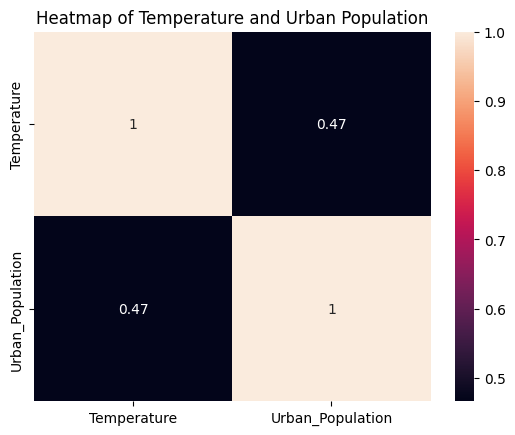


ADF Test for Average Temperature
ADF Statistic: -3.4066703548963684
P value: 0.010733570588527978
Used Lag: 0

ADF Test for Urban Population
ADF Statistic: -1.7776647806432928
P value: 0.39160552447873126
Used Lag: 0
Isolation Forest Results Summary
Outlier_Label
Normal     125
Outlier      7
Name: count, dtype: int64

Detected Outliers
    Temperature  Urban_Population
25         32.6             9.152
49         32.3            18.878
58         29.9            23.774
60         33.6            24.954
61         34.2            25.553
62         32.2            26.159
63         32.4            26.771


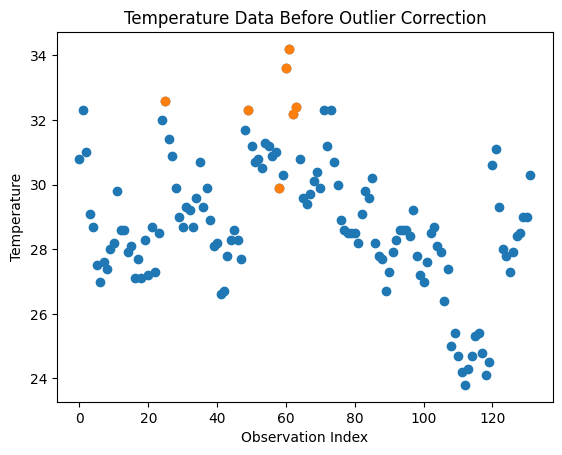

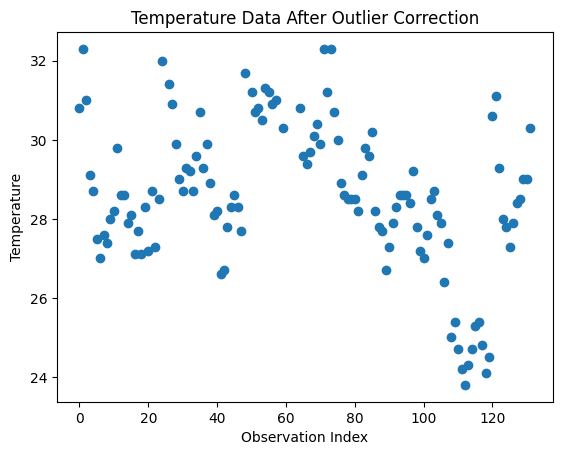


Original data size: 132
Cleaned data size: 125


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from scipy.stats import pearsonr

# Step 2: Read dataset (already uploaded via files.upload())
file_path = "Temperature Data.xlsx"
df = pd.read_excel(file_path)
df.columns = ["City", "Temperature", "Urban_Population"]

print("\nDescriptive Statistics\n")
print(df.describe())

plt.figure()
sns.heatmap(df[["Temperature", "Urban_Population"]].corr(), annot=True)
plt.title("Heatmap of Temperature and Urban Population")
plt.show()

def adf_test(series, name):
    result = adfuller(series, autolag="AIC")
    print(f"\nADF Test for {name}")
    print(f"ADF Statistic: {result[0]}")
    print(f"P value: {result[1]}")
    print(f"Used Lag: {result[2]}")

adf_test(df["Temperature"], "Average Temperature")
adf_test(df["Urban_Population"], "Urban Population")

# Fit Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
df["Outlier"] = iso.fit_predict(df[["Temperature", "Urban_Population"]])

# Map results to readable labels
df["Outlier_Label"] = df["Outlier"].map({1: "Normal", -1: "Outlier"})

# Print summary of results
print("Isolation Forest Results Summary")
print(df["Outlier_Label"].value_counts())

# Display detected outliers
print("\nDetected Outliers")
print(df[df["Outlier"] == -1][["Temperature", "Urban_Population"]])

# Plot BEFORE outlier correction (actual data)
plt.figure()
plt.scatter(df.index, df["Temperature"])
plt.scatter(
    df[df["Outlier"] == -1].index,
    df[df["Outlier"] == -1]["Temperature"]
)
plt.title("Temperature Data Before Outlier Correction")
plt.xlabel("Observation Index")
plt.ylabel("Temperature")
plt.show()

# Remove outliers
df_clean = df[df["Outlier"] == 1].drop(columns=["Outlier", "Outlier_Label"])

# Plot AFTER outlier correction (cleaned data)
plt.figure()
plt.scatter(df_clean.index, df_clean["Temperature"])
plt.title("Temperature Data After Outlier Correction")
plt.xlabel("Observation Index")
plt.ylabel("Temperature")
plt.show()

# Confirm cleaned data size
print("\nOriginal data size:", df.shape[0])
print("Cleaned data size:", df_clean.shape[0])

Model Fitting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from scipy.stats import pearsonr

# Step 2: Read dataset (already uploaded via files.upload())
file_path = "Temperature Data.xlsx"
df = pd.read_excel(file_path)
df.columns = ["City", "Temperature", "Urban_Population"]

# TRAIN TEST SPLIT
train_size = int(len(df_clean) * 0.8)
train = df_clean.iloc[:train_size]
test = df_clean.iloc[train_size:]

y_train = train["Temperature"].values
y_test = test["Temperature"].values
x_train = train["Urban_Population"].values
x_test = test["Urban_Population"].values

# PERFORMANCE METRICS
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, smape, r2

# DEEP LEARNING BENCHMARKS
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_clean[["Temperature"]])

def create_seq(data, n_steps=3):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Create sequences from the entire scaled dataset
X_seq, y_seq = create_seq(scaled)

# Determine the split points for deep learning data to align test set length with y_test
dl_test_samples = len(y_test)
dl_train_samples = len(y_seq) - dl_test_samples

X_train_dl_seq, X_test_dl_seq = X_seq[:dl_train_samples], X_seq[dl_train_samples:]
y_train_dl_seq, y_test_dl_seq = y_seq[:dl_train_samples], y_seq[dl_train_samples:]

# Generic builder for recurrent models, now accepting input_seq_shape
def build_model(cell, input_seq_shape, bidirectional=False):
    model = Sequential()

    if bidirectional:
        model.add(
            Bidirectional(
                cell(50, activation="tanh"),
                input_shape=input_seq_shape
            )
        )
    else:
        model.add(
            cell(50, activation="tanh", input_shape=input_seq_shape)
        )

    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

# ARIMA MODEL
# Train ARIMA on the training data
auto_arima = pm.auto_arima(y_train, seasonal=False)
arima_model = ARIMA(y_train, order=auto_arima.order).fit()

print("\nARIMA Parameters")
print(arima_model.params)

# Forecast for the test period
arima_pred = arima_model.forecast(len(y_test))

#ARIMA-LSTM HYBRID
# Calculate residuals from ARIMA model on TRAINING data
residuals_train = y_train - arima_model.fittedvalues
scaler_res = MinMaxScaler() # Use a separate scaler for residuals
res_scaled_train = scaler_res.fit_transform(residuals_train.reshape(-1,1))

# Create sequences for LSTM training from scaled residuals
n_steps = 3 # from create_seq function
Xr_train_res, yr_train_res = create_seq(res_scaled_train, n_steps=n_steps)
lstm_res = build_model(LSTM, (Xr_train_res.shape[1], 1)) # input_shape must be consistent with Xr_train_res
lstm_res.fit(Xr_train_res, yr_train_res, epochs=30, verbose=0)

# Forecast future residuals for the test period iteratively
res_forecast_list = []
# Initialize with the last n_steps of training residuals
current_input_res = res_scaled_train[-n_steps:].reshape(1, n_steps, 1)

for _ in range(len(y_test)):
    next_residual_scaled = lstm_res.predict(current_input_res, verbose=0)[0, 0] # verbose=0 to suppress output
    res_forecast_list.append(next_residual_scaled)
    # Update current_input by removing the first element and adding the new prediction
    # This creates a sliding window for multi-step forecasting
    current_input_res = np.append(current_input_res[:, 1:, :], [[[next_residual_scaled]]], axis=1)

res_forecast = scaler_res.inverse_transform(np.array(res_forecast_list).reshape(-1, 1)).flatten()
hybrid_pred = arima_pred + res_forecast

print("\nHybrid Model Parameters")
print(lstm_res.summary())


# FACEBOOK PROPHET
prophet_df = df_clean.reset_index()
prophet_df["ds"] = pd.date_range(start="2017", periods=len(prophet_df), freq="M")
prophet_df.rename(columns={"Temperature":"y"}, inplace=True)

model_p = Prophet()
model_p.fit(prophet_df.iloc[:train_size])

future = model_p.make_future_dataframe(periods=len(y_test), freq="M")
forecast = model_p.predict(future)
prophet_pred = forecast["yhat"].iloc[-len(y_test):].values

# MACHINE LEARNING BENCHMARKS

X_ml = df_clean[["Urban_Population"]]
# Split ML data into train and test
X_train_ml, X_test_ml = X_ml.iloc[:train_size], X_ml.iloc[train_size:]

ml_models = {
    "RandomForest": RandomForestRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "SVR": SVR(),
    "GBM": GradientBoostingRegressor(),
    "KNN": KNeighborsRegressor()
}

predictions = {}
for name, model in ml_models.items():
    # Train ML models on training data
    model.fit(X_train_ml, y_train)
    # Predict on test data
    pred = model.predict(X_test_ml)
    predictions[name] = pred
    print(f"\n{name} Parameters")
    print(model.get_params())


# Deep learning models
# Build models with appropriate input shape for training data
models_dl = {
    "LSTM": build_model(LSTM, (X_train_dl_seq.shape[1], 1)),
    "RNN": build_model(SimpleRNN, (X_train_dl_seq.shape[1], 1)),
    "GRU": build_model(GRU, (X_train_dl_seq.shape[1], 1)),
    "BiLSTM": build_model(LSTM, (X_train_dl_seq.shape[1], 1), bidirectional=True),
    "BiGRU": build_model(GRU, (X_train_dl_seq.shape[1], 1), bidirectional=True),
    "BiRNN": build_model(SimpleRNN, (X_train_dl_seq.shape[1], 1), bidirectional=True),
}

# MLP requires flattened input
mlp = Sequential()
mlp.add(Dense(50, activation="relu", input_dim=X_train_dl_seq.shape[1]))
mlp.add(Dense(1))
mlp.compile(optimizer="adam", loss="mse")

models_dl["MLP"] = mlp

# Train deep learning models on training data and predict on test data
for name, model in models_dl.items():
    # Train on training sequences
    model.fit(X_train_dl_seq if name != "MLP" else X_train_dl_seq.reshape(X_train_dl_seq.shape[0], -1),
              y_train_dl_seq,
              epochs=30,
              verbose=0)

    # Predict on test sequences
    preds = model.predict(
        X_test_dl_seq if name != "MLP" else X_test_dl_seq.reshape(X_test_dl_seq.shape[0], -1),
        verbose=0 # Suppress predict output for each model
    )

    predictions[name] = scaler.inverse_transform(preds).flatten()

# MODEL COMPARISON
# Initialize results dictionary
results = {}

# Explicit list of deep learning benchmark models
deep_learning_models = [
    "LSTM",
    "RNN",
    "GRU",
    "BiGRU",
    "BiRNN",
    "MLP"
]

# Explicit list of machine learning benchmark models
machine_learning_models = [
    "RandomForest",
    "DecisionTree",
    "SVR",
    "GBM",
    "KNN"
]

# Add ARIMA
results["ARIMA"] = metrics(y_test, arima_pred)

# Add Facebook Prophet
results["Prophet"] = metrics(y_test, prophet_pred)

# Add ARIMA-LSTM Hybrid
results["ARIMA-LSTM"] = metrics(y_test, hybrid_pred)

# Add Deep Learning Models
for model in deep_learning_models:
    if model in predictions:
        results[model] = metrics(y_test, predictions[model])

# Add Machine Learning Models
for model in machine_learning_models:
    if model in predictions:
        results[model] = metrics(y_test, predictions[model])

# Create comparison table
results_df = pd.DataFrame(
    results,
    index=["RMSE", "MAE", "MAPE", "SMAPE", "R2"]
).T

# Sort models by RMSE (best on top)
results_df = results_df.sort_values(by="RMSE")

print("\nMODEL PERFORMANCE COMPARISON\n")
print(results_df.round(4))


ARIMA Parameters
[29.00051945  0.76758468  0.88350376]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Hybrid Model Parameters


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

/tmp/ipython-input-2336617055.py:130: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prophet_df["ds"] = pd.date_range(start="2017", periods=len(prophet_df), freq="M")
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


None


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



RandomForest Parameters
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

DecisionTree Parameters
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

SVR Parameters
{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

GBM Parameters
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MODEL PERFORMANCE COMPARISON

                RMSE     MAE    MAPE   SMAPE      R2
BiRNN         1.4938  0.9653  3.4933  3.5448  0.5628
BiGRU         1.8048  1.4498  5.4638  5.4079  0.3619
RNN           1.8183  1.3121  4.8390  4.8447  0.3523
LSTM          1.9598  1.6438  6.1795  6.1158  0.2476
MLP           1.9851  1.6083  6.0460  5.9884  0.2280
GRU           2.0572  1.7377  6.6355  6.4774  0.1710
KNN           2.1809  1.8584  7.1667  6.9384  0.0682
RandomForest  2.2323  1.9281  7.4607  7.1889  0.0238
GBM           2.2612  1.9393  7.5179  7.2291 -0.0017
DecisionTree  2.2908  1.9800  7.6961  7.3768 -0.0280
Prophet       2.5978  2.4297  9.0119  9.0531 -0.3220
SVR           2.6897  2.2507  8.7948  8.3409 -0.4172
ARIMA-LSTM    2.7078  2.2324  8.7741  8.2697 -0.4364
ARIMA         2.7956  2.2940  9.0330  8.4856 -0.5310



ARIMA Parameters
[29.21344638  0.74678495  0.92551191]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Hybrid Model Parameters


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

/tmp/ipython-input-3139806538.py:130: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prophet_df["ds"] = pd.date_range(start="2017", periods=len(prophet_df), freq="M")
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


None


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



RandomForest Parameters
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

DecisionTree Parameters
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

SVR Parameters
{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

GBM Parameters
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MODEL PERFORMANCE COMPARISON

                RMSE     MAE    MAPE   SMAPE      R2
BiRNN         1.2776  0.8300  3.0368  3.0434  0.5774
MLP           1.4891  1.0614  3.9157  3.9064  0.4259
BiGRU         1.5582  1.1905  4.4601  4.4027  0.3713
RNN           1.5616  1.0998  4.0328  4.0305  0.3686
GRU           1.6163  1.2559  4.7191  4.6452  0.3236
LSTM          1.7550  1.3997  5.2713  5.1669  0.2025
RandomForest  1.8622  1.4295  5.4990  5.3086  0.1021
DecisionTree  1.8864  1.5605  5.9261  5.7740  0.0786
GBM           1.9190  1.5062  5.7782  5.5826  0.0465
KNN           2.1779  1.6511  6.3950  6.0963 -0.2281
SVR           2.3415  1.7699  6.8776  6.5179 -0.4196
Prophet       2.3781  1.8977  6.8644  7.0819 -0.4644
ARIMA-LSTM    2.7281  2.1282  8.2854  7.7561 -0.9270
ARIMA         2.7774  2.1776  8.4755  7.9250 -0.9974


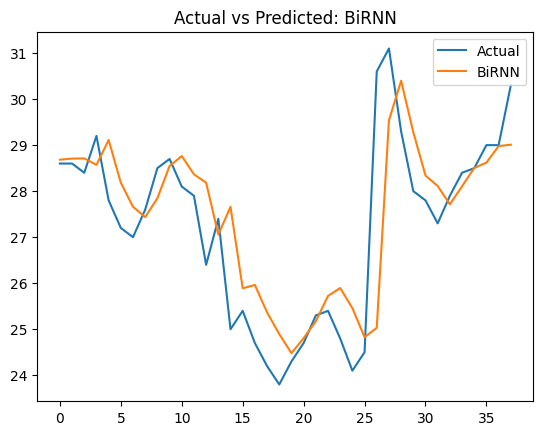

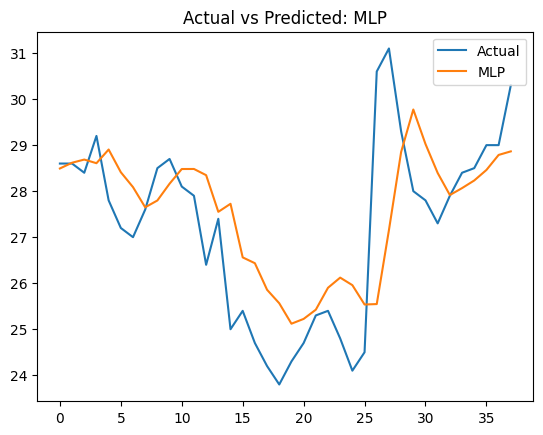

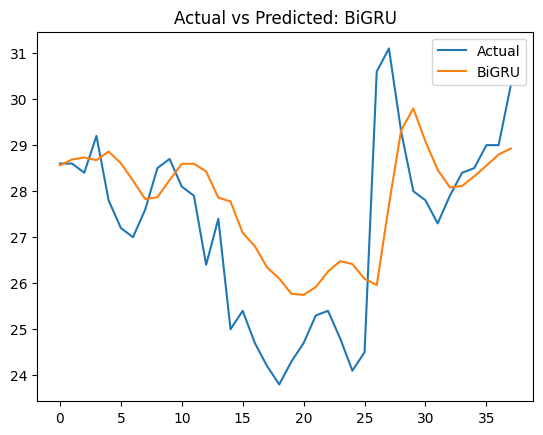

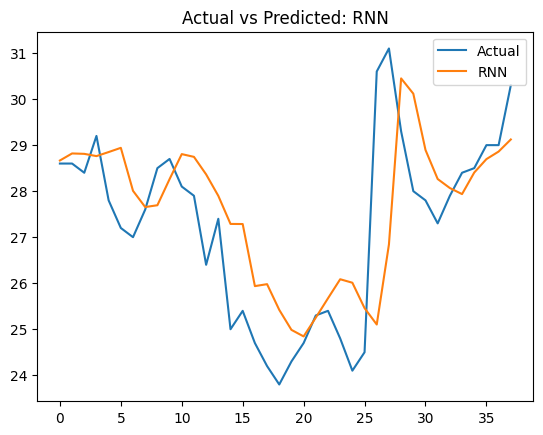

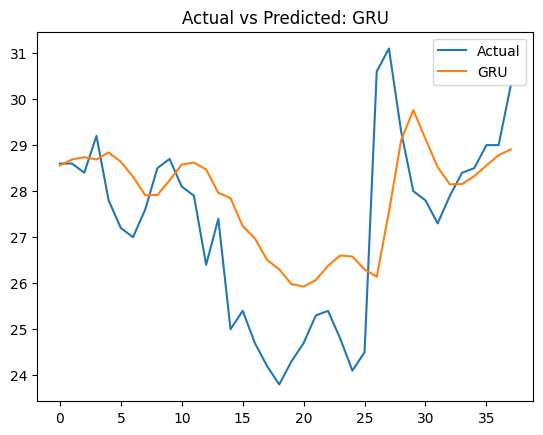

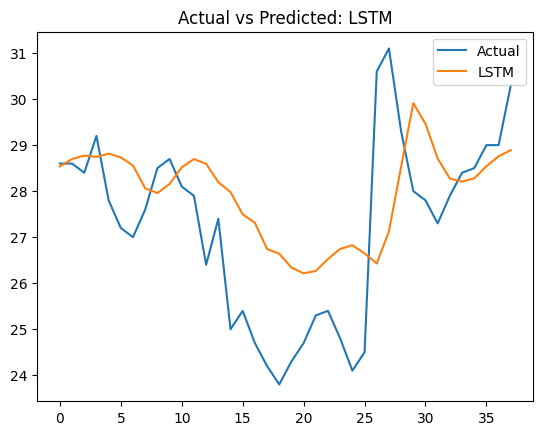

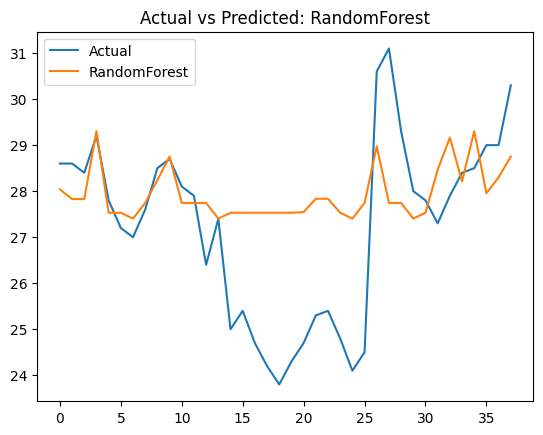

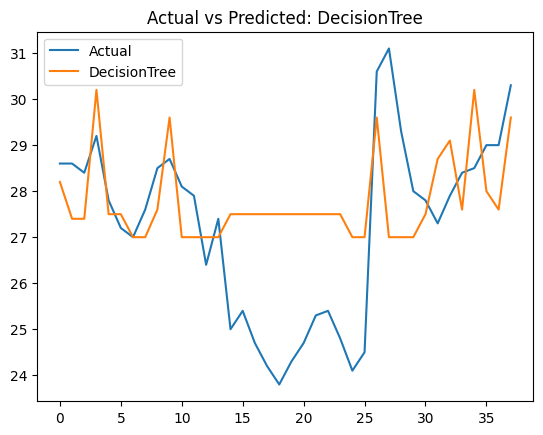

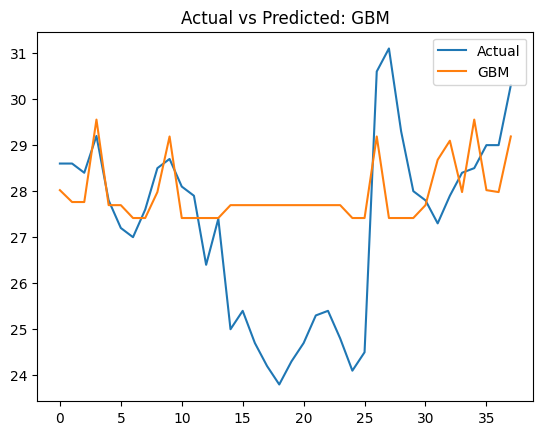

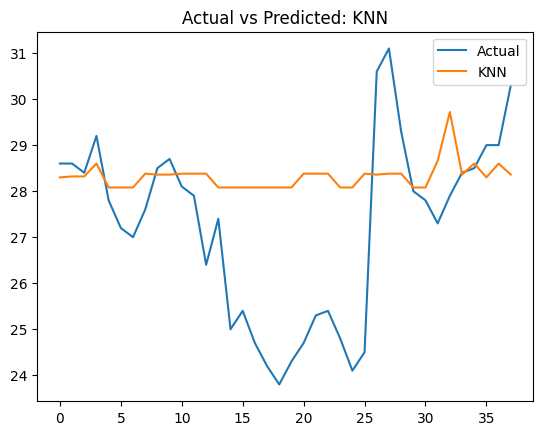

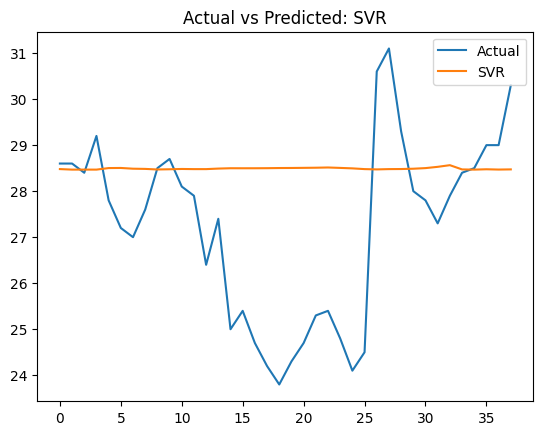

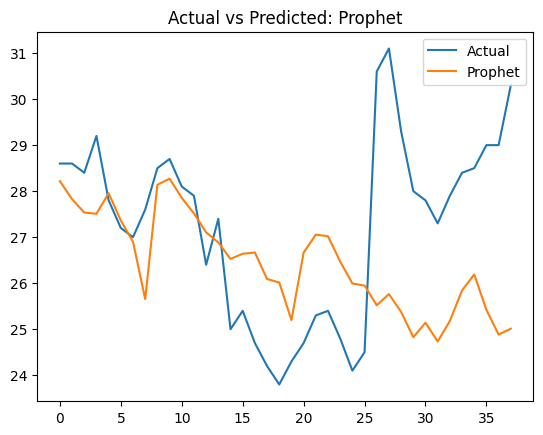

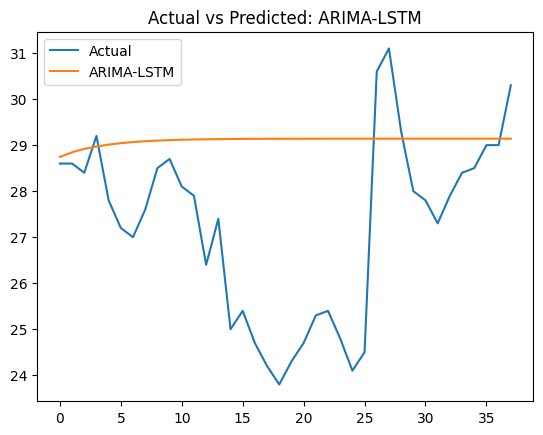


Correlation between Actual (Test) and Hybrid Prediction (Test): -0.2545995826640929

Forecasted Average Temperature for Next 12 Years
[28.74390811 28.8447047  28.9190437  28.96863651 29.01147723 29.04313056
 29.066654   29.08501476 29.09874351 29.10908874 29.1169429  29.12283672
 29.12727208 29.13061039 29.1331156  29.13499563 29.13640617 29.13746351
 29.13825548 29.13884888 29.13929293 29.13962528 29.13987413 29.14006043
 29.1401989  29.14030324 29.14038099 29.14043889 29.14048246 29.14051495
 29.14053933 29.14055738 29.14057098 29.14058114 29.14058872 29.14059438
 29.14059861 29.14060177 29.14060413 29.14060589 29.14060721 29.14060819
 29.14060892 29.14060947 29.14060988 29.14061019 29.14061042 29.14061059
 29.14061071 29.14061081 29.14061088 29.14061093 29.14061097 29.140611
 29.14061102 29.14061104 29.14061105 29.14061106 29.14061107 29.14061107
 29.14061108 29.14061108 29.14061108 29.14061108 29.14061108 29.14061109
 29.14061109 29.14061109 29.14061109 29.14061109 29.14061109 29.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from scipy.stats import pearsonr

# Step 2: Read dataset (already uploaded via files.upload())
file_path = "Temperature Data.xlsx"
df = pd.read_excel(file_path)
df.columns = ["City", "Temperature", "Urban_Population"]

# TRAIN TEST SPLIT
train_size = int(len(df_clean) * 0.7)
train = df_clean.iloc[:train_size]
test = df_clean.iloc[train_size:]

y_train = train["Temperature"].values
y_test = test["Temperature"].values
x_train = train["Urban_Population"].values
x_test = test["Urban_Population"].values

# PERFORMANCE METRICS
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, smape, r2

# DEEP LEARNING BENCHMARKS
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_clean[["Temperature"]])

def create_seq(data, n_steps=3):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Create sequences from the entire scaled dataset
X_seq, y_seq = create_seq(scaled)

# Determine the split points for deep learning data to align test set length with y_test
dl_test_samples = len(y_test)
dl_train_samples = len(y_seq) - dl_test_samples

X_train_dl_seq, X_test_dl_seq = X_seq[:dl_train_samples], X_seq[dl_train_samples:]
y_train_dl_seq, y_test_dl_seq = y_seq[:dl_train_samples], y_seq[dl_train_samples:]

# Generic builder for recurrent models, now accepting input_seq_shape
def build_model(cell, input_seq_shape, bidirectional=False):
    model = Sequential()

    if bidirectional:
        model.add(
            Bidirectional(
                cell(50, activation="tanh"),
                input_shape=input_seq_shape
            )
        )
    else:
        model.add(
            cell(50, activation="tanh", input_shape=input_seq_shape)
        )

    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

# ARIMA MODEL
# Train ARIMA on the training data
auto_arima = pm.auto_arima(y_train, seasonal=False)
arima_model = ARIMA(y_train, order=auto_arima.order).fit()

print("\nARIMA Parameters")
print(arima_model.params)

# Forecast for the test period
arima_pred = arima_model.forecast(len(y_test))

#ARIMA-LSTM HYBRID
# Calculate residuals from ARIMA model on TRAINING data
residuals_train = y_train - arima_model.fittedvalues
scaler_res = MinMaxScaler() # Use a separate scaler for residuals
res_scaled_train = scaler_res.fit_transform(residuals_train.reshape(-1,1))

# Create sequences for LSTM training from scaled residuals
n_steps = 3 # from create_seq function
Xr_train_res, yr_train_res = create_seq(res_scaled_train, n_steps=n_steps)
lstm_res = build_model(LSTM, (Xr_train_res.shape[1], 1)) # input_shape must be consistent with Xr_train_res
lstm_res.fit(Xr_train_res, yr_train_res, epochs=30, verbose=0)

# Forecast future residuals for the test period iteratively
res_forecast_list = []
# Initialize with the last n_steps of training residuals
current_input_res = res_scaled_train[-n_steps:].reshape(1, n_steps, 1)

for _ in range(len(y_test)):
    next_residual_scaled = lstm_res.predict(current_input_res, verbose=0)[0, 0] # verbose=0 to suppress output
    res_forecast_list.append(next_residual_scaled)
    # Update current_input by removing the first element and adding the new prediction
    # This creates a sliding window for multi-step forecasting
    current_input_res = np.append(current_input_res[:, 1:, :], [[[next_residual_scaled]]], axis=1)

res_forecast = scaler_res.inverse_transform(np.array(res_forecast_list).reshape(-1, 1)).flatten()
hybrid_pred = arima_pred + res_forecast

print("\nHybrid Model Parameters")
print(lstm_res.summary())


# FACEBOOK PROPHET
prophet_df = df_clean.reset_index()
prophet_df["ds"] = pd.date_range(start="2017", periods=len(prophet_df), freq="M")
prophet_df.rename(columns={"Temperature":"y"}, inplace=True)

model_p = Prophet()
model_p.fit(prophet_df.iloc[:train_size])

future = model_p.make_future_dataframe(periods=len(y_test), freq="M")
forecast = model_p.predict(future)
prophet_pred = forecast["yhat"].iloc[-len(y_test):].values

# MACHINE LEARNING BENCHMARKS

X_ml = df_clean[["Urban_Population"]]
y_ml = df_clean[["Temperature"]]
# Split ML data into train and test
X_train_ml, X_test_ml = X_ml.iloc[:train_size], X_ml.iloc[train_size:]
y_train_ml, y_test_ml = y_ml.iloc[:train_size], y_ml.iloc[train_size:]

ml_models = {
    "RandomForest": RandomForestRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "SVR": SVR(),
    "GBM": GradientBoostingRegressor(),
    "KNN": KNeighborsRegressor()
}

predictions = {}
for name, model in ml_models.items():
    # Train ML models on training data
    model.fit(X_train_ml, y_train)
    # Predict on test data
    pred = model.predict(X_test_ml)
    predictions[name] = pred
    print(f"\n{name} Parameters")
    print(model.get_params())

# Add Prophet predictions to the dictionary as well
predictions["Prophet"] = prophet_pred

# Deep learning models
# Build models with appropriate input shape for training data
models_dl = {
    "LSTM": build_model(LSTM, (X_train_dl_seq.shape[1], 1)),
    "RNN": build_model(SimpleRNN, (X_train_dl_seq.shape[1], 1)),
    "GRU": build_model(GRU, (X_train_dl_seq.shape[1], 1)),
    "BiLSTM": build_model(LSTM, (X_train_dl_seq.shape[1], 1), bidirectional=True),
    "BiGRU": build_model(GRU, (X_train_dl_seq.shape[1], 1), bidirectional=True),
    "BiRNN": build_model(SimpleRNN, (X_train_dl_seq.shape[1], 1), bidirectional=True),
}

# MLP requires flattened input
mlp = Sequential()
mlp.add(Dense(50, activation="relu", input_dim=X_train_dl_seq.shape[1]))
mlp.add(Dense(1))
mlp.compile(optimizer="adam", loss="mse")

models_dl["MLP"] = mlp

# Train deep learning models on training data and predict on test data
for name, model in models_dl.items():
    # Train on training sequences
    model.fit(X_train_dl_seq if name != "MLP" else X_train_dl_seq.reshape(X_train_dl_seq.shape[0], -1),
              y_train_dl_seq,
              epochs=30,
              verbose=0)

    # Predict on test sequences
    preds = model.predict(
        X_test_dl_seq if name != "MLP" else X_test_dl_seq.reshape(X_test_dl_seq.shape[0], -1),
        verbose=0 # Suppress predict output for each model
    )

    predictions[name] = scaler.inverse_transform(preds).flatten()

# MODEL COMPARISON
# Initialize results dictionary
results = {}

# Explicit list of deep learning benchmark models
deep_learning_models = [
    "LSTM",
    "RNN",
    "GRU",
    "BiGRU",
    "BiRNN",
    "MLP"
]

# Explicit list of machine learning benchmark models
machine_learning_models = [
    "RandomForest",
    "DecisionTree",
    "SVR",
    "GBM",
    "KNN"
]

# Add ARIMA
results["ARIMA"] = metrics(y_test, arima_pred)

# Add Facebook Prophet
results["Prophet"] = metrics(y_test, prophet_pred)

# Add ARIMA-LSTM Hybrid
results["ARIMA-LSTM"] = metrics(y_test, hybrid_pred)

# Add Deep Learning Models
for model in deep_learning_models:
    if model in predictions:
        results[model] = metrics(y_test, predictions[model])

# Add Machine Learning Models
for model in machine_learning_models:
    if model in predictions:
        results[model] = metrics(y_test, predictions[model])

# Create comparison table
results_df = pd.DataFrame(
    results,
    index=["RMSE", "MAE", "MAPE", "SMAPE", "R2"]
).T

# Sort models by RMSE (best on top)
results_df = results_df.sort_values(by="RMSE")

print("\nMODEL PERFORMANCE COMPARISON\n")
print(results_df.round(4))

# VISUALIZATION ACTUAL VS PREDICTED
for name in results_df.index[:-1]: # Iterate only over names
    plt.figure()
    plt.plot(y_test, label="Actual")
    # Check if the model name exists in predictions dictionary before plotting
    if name in predictions:
        plt.plot(predictions[name], label=name)
    else:
        # Handle cases where predictions might not be available for a model (e.g., ARIMA/ARIMA-LSTM are not in `predictions` yet)
        # For ARIMA and ARIMA-LSTM, their predictions are in `arima_pred` and `hybrid_pred` respectively.
        if name == "ARIMA":
            plt.plot(arima_pred, label=name)
        elif name == "ARIMA-LSTM":
            plt.plot(hybrid_pred, label=name)
        # Add other specific cases if any model's prediction is not in the `predictions` dict


    plt.legend()
    plt.title(f"Actual vs Predicted: {name}")
    plt.show()

# CORRELATION CHECK FOR HYBRID MODEL
# Correlation should be between actual test values and hybrid predictions for the test set
corr, _ = pearsonr(y_test, hybrid_pred)
print("\nCorrelation between Actual (Test) and Hybrid Prediction (Test):", corr)

# 12 YEAR FORECAST USING HYBRID MODEL
# For forecasting beyond the test set, ensure the LSTM starts from the end of all available data (train+test)
# The original LSTM was trained on residuals from training data (residuals_train)
# To maintain the existing structure where lstm_res was trained on residuals_train, we'll continue forecasting from there.
# The current current_input_res is already set up to iterate from the last n_steps of training residuals.
# However, for a true '12 year forecast', we'd ideally use all data to train the final model.
# Let's keep it consistent with the existing ARIMA/LSTM training for now, i.e., forecasting from the end of the training set context.

# The current code `future_res = scaler.inverse_transform(lstm_res.predict(Xr[-12*12:]))` is flawed
# because Xr is Xr_train_res (length 97), and predicting 144 steps from it directly is not multi-step forecasting.
# We need to use the iterative prediction approach for future forecasts too.

future_res_list = []
# Start future residual forecasting from the end of the data used for training the LSTM residuals model (res_scaled_train)
current_input_res_future = res_scaled_train[-n_steps:].reshape(1, n_steps, 1)

for _ in range(12 * 12):
    next_residual_scaled_future = lstm_res.predict(current_input_res_future, verbose=0)[0, 0]
    future_res_list.append(next_residual_scaled_future)
    current_input_res_future = np.append(current_input_res_future[:, 1:, :], [[[next_residual_scaled_future]]], axis=1)

future_res = scaler_res.inverse_transform(np.array(future_res_list).reshape(-1, 1)).flatten()

# ARIMA model needs to forecast for 12*12 steps from the end of its training data (y_train)
future_arima = arima_model.forecast(12*12)

future_temp = future_arima + future_res
print("\nForecasted Average Temperature for Next 12 Years")
print(future_temp)


In [29]:
# Step 1: Upload file manually
from google.colab import files
import pandas as pd

uploaded = files.upload()  # This lets you pick file from your PC
file_path = list(uploaded.keys())[0]  # Automatically use uploaded filename

# Step 2: Read dataset
# Use pd.read_excel for .xlsx files
data = pd.read_excel(file_path)
print("Temperature Data (first 5 rows):")
print(data.head())

Saving Temperature Data.xlsx to Temperature Data (2).xlsx
Temperature Data (first 5 rows):
   Date  City  Temperature  Urban_Population
0  2012  ARUA         30.8             4.417
1  2013  ARUA         32.3             4.617
2  2014  ARUA         31.0             4.826
3  2015  ARUA         29.1             5.045
4  2016  ARUA         28.7             5.273



ARIMA Parameters
[29.21344638  0.74678495  0.92551191]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Hybrid Model Parameters


Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

/tmp/ipython-input-2595962273.py:135: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prophet_df["ds"] = pd.date_range(start="2017", periods=len(prophet_df), freq="M")
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


None


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



RandomForest Parameters
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

DecisionTree Parameters
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}

SVR Parameters
{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}

GBM Parameters
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedma

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MODEL PERFORMANCE COMPARISON

                RMSE     MAE    MAPE   SMAPE      R2
RNN           1.3878  0.9547  3.4987  3.4986  0.5013
MLP           1.4337  1.0812  4.0397  3.9954  0.4678
BiRNN         1.6022  1.1766  4.3512  4.3235  0.3354
GRU           1.6443  1.2879  4.8569  4.7672  0.3000
BiGRU         1.6713  1.3144  4.9439  4.8594  0.2767
LSTM          1.7529  1.3974  5.2596  5.1574  0.2044
RandomForest  1.8439  1.4244  5.4712  5.2906  0.1197
DecisionTree  1.8864  1.5605  5.9261  5.7740  0.0786
GBM           1.9190  1.5062  5.7782  5.5826  0.0465
KNN           2.1779  1.6511  6.3950  6.0963 -0.2281
SVR           2.3415  1.7699  6.8776  6.5179 -0.4196
Prophet       2.3781  1.8977  6.8644  7.0819 -0.4644
ARIMA-LSTM    2.7244  2.1242  8.2699  7.7422 -0.9218
ARIMA         2.7774  2.1776  8.4755  7.9250 -0.9974


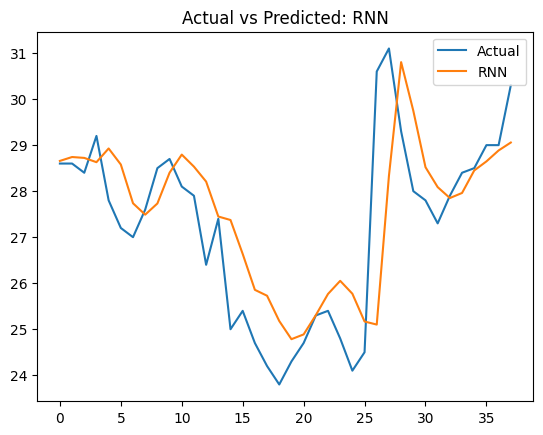

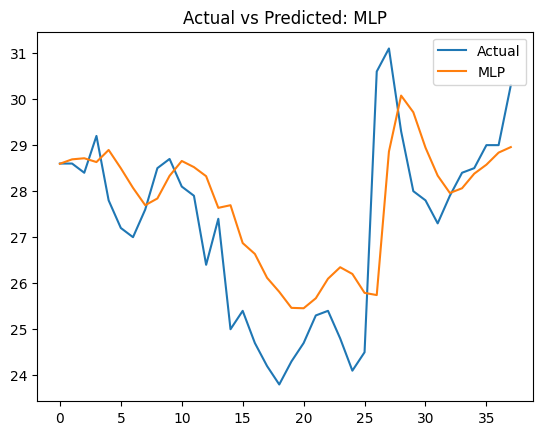

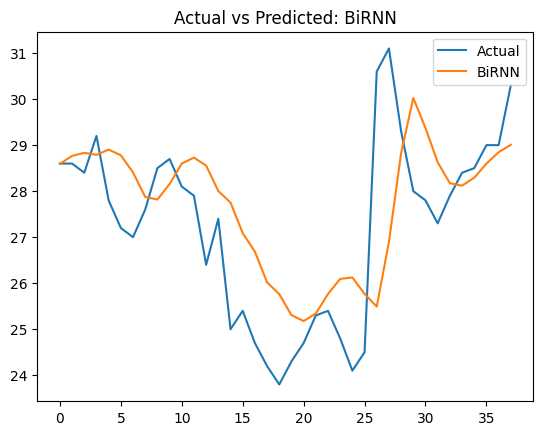

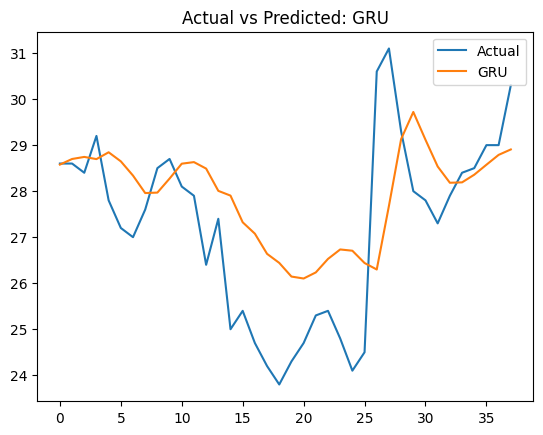

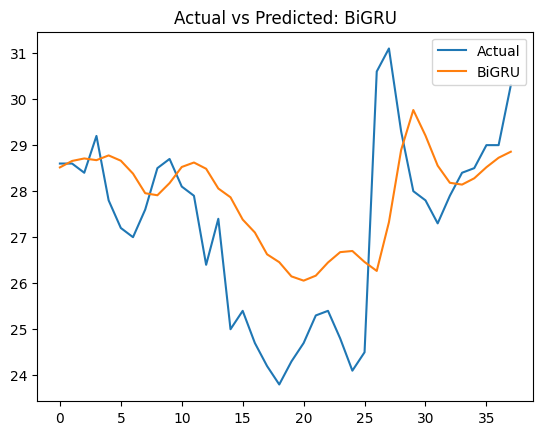

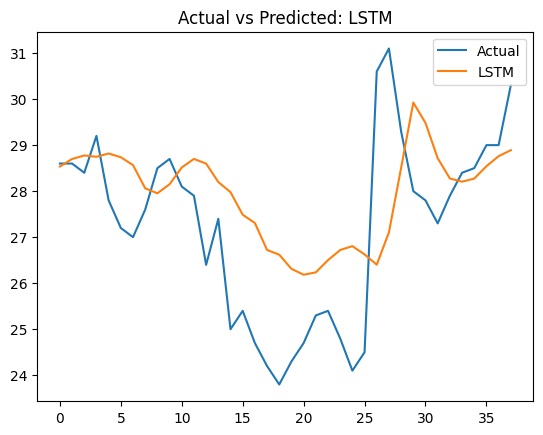

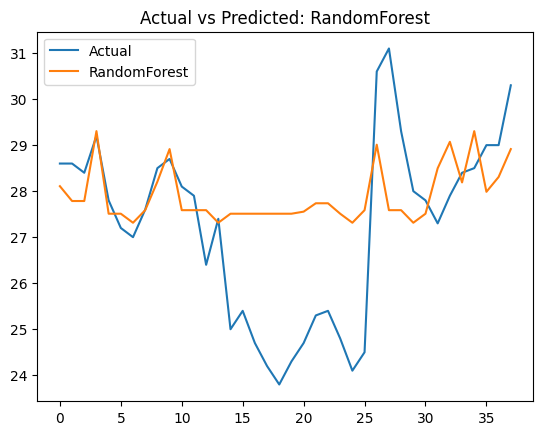

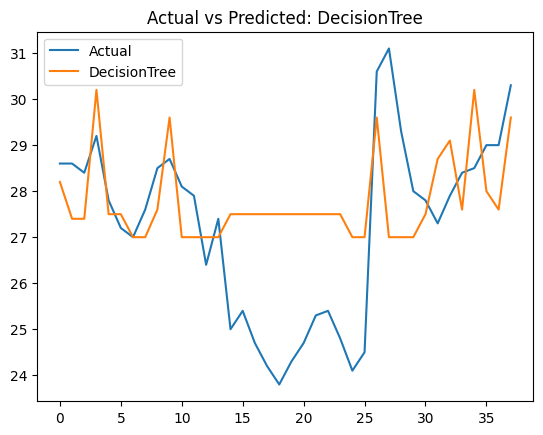

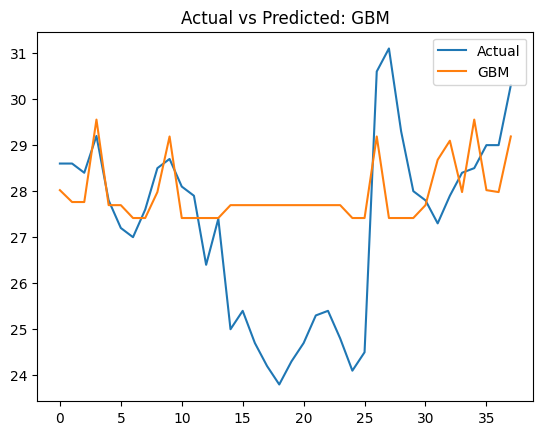

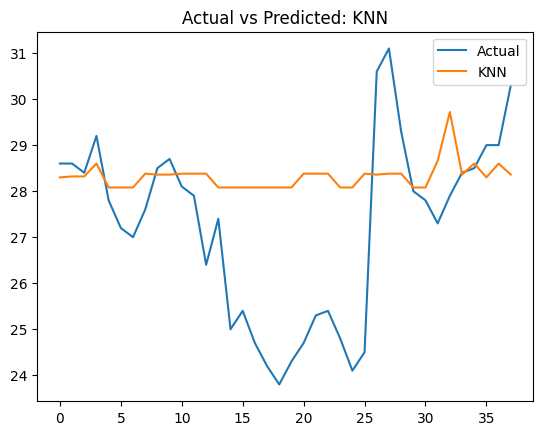

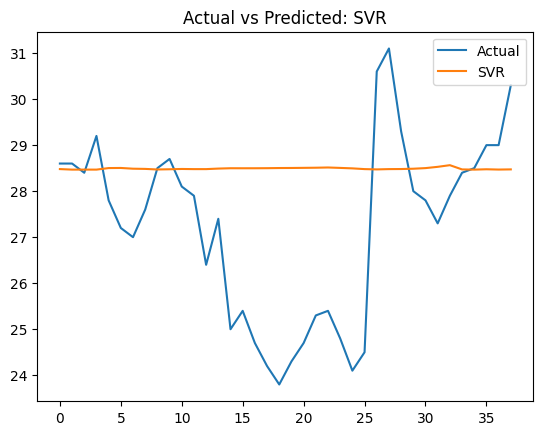

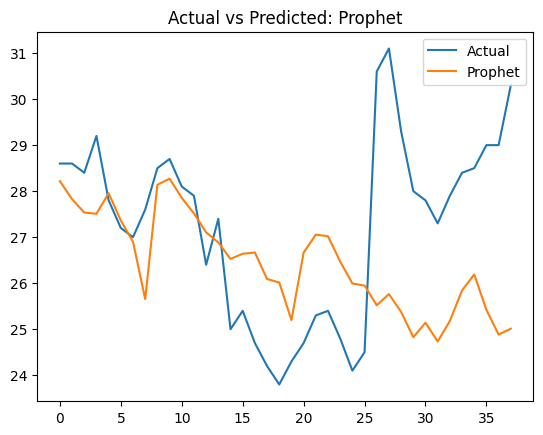

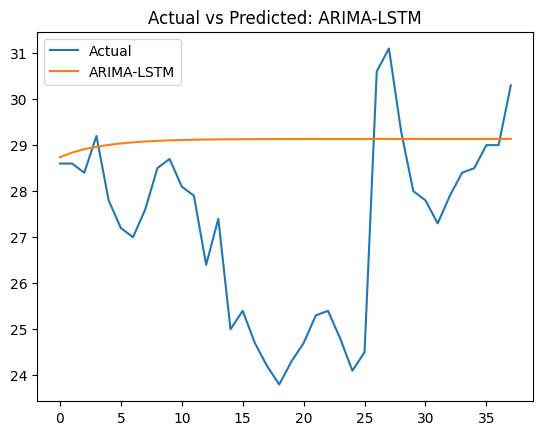


Correlation between Actual (Test) and Hybrid Prediction (Test): -0.25469157543759724

CLASSIFICATION METRICS (Derived Temperature States)

              Accuracy  Precision  Sensitivity  F1_score     AUC
ARIMA           0.2368     0.1944       1.0000    0.3256  0.7880
Prophet         0.8158     0.0000       0.0000    0.0000  0.2212
ARIMA-LSTM      0.2368     0.1944       1.0000    0.3256  0.7880
RandomForest    0.8158     0.5000       0.4286    0.4615  0.8018
DecisionTree    0.8158     0.5000       0.4286    0.4615  0.6889
SVR             0.8158     0.0000       0.0000    0.0000  0.1705
GBM             0.8158     0.5000       0.4286    0.4615  0.6912
KNN             0.7895     0.0000       0.0000    0.0000  0.7212
LSTM            0.7632     0.0000       0.0000    0.0000  0.6221
RNN             0.8158     0.5000       0.2857    0.3636  0.7465
GRU             0.8158     0.5000       0.2857    0.3636  0.6866
BiLSTM          0.7895     0.3333       0.1429    0.2000  0.6866
BiGRU          

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),


        Date  Forecasted_Temperature
0 2024-12-31                  30.244
1 2025-12-31                  30.065
2 2026-12-31                  29.556
3 2027-12-31                  28.754
4 2028-12-31                  28.414
5 2029-12-31                  28.342
6 2030-12-31                  28.437


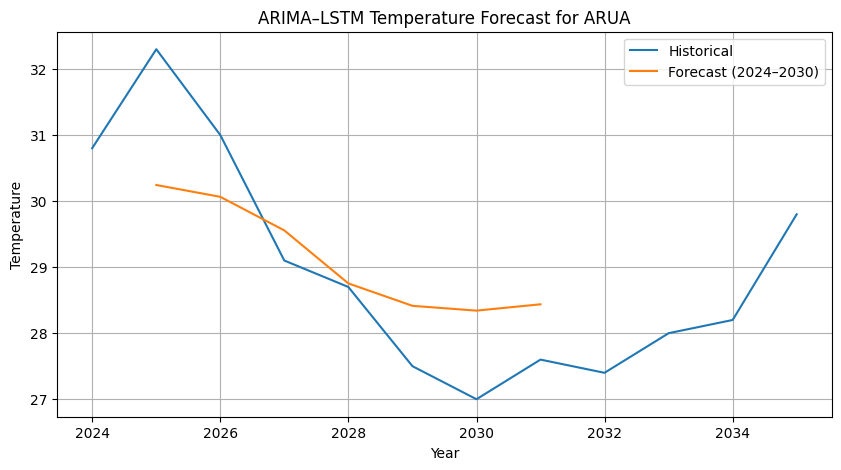


===== Forecast for ENTEBBE =====


/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(3,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/pmdarima/arima/arima.py", line 610, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.12/dist-packages/pmdarima/arima/arima.py", line 531, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pmdarima/arima/arima.py", line 517, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 705, in fit
    mlefit = super().fit(start_pa

        Date  Forecasted_Temperature
0 2024-12-31                  27.079
1 2025-12-31                  28.243
2 2026-12-31                  27.079
3 2027-12-31                  28.295
4 2028-12-31                  27.176
5 2029-12-31                  28.328
6 2030-12-31                  27.233


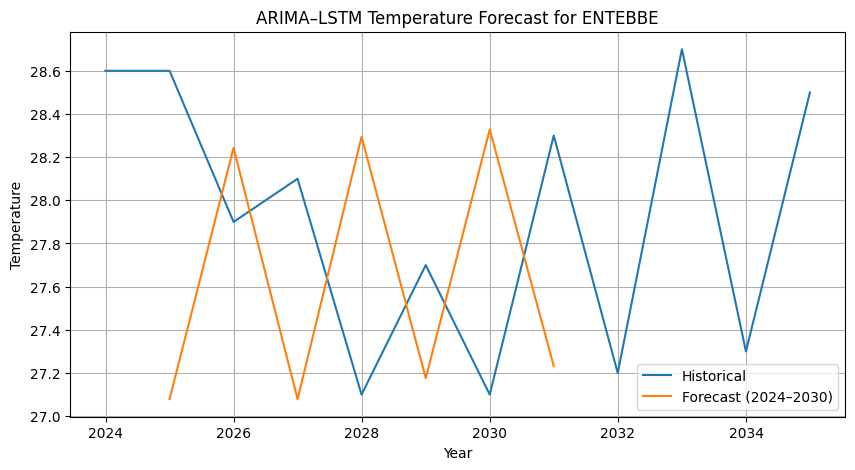


===== Forecast for GULU =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),


        Date  Forecasted_Temperature
0 2024-12-31                  31.211
1 2025-12-31                  31.487
2 2026-12-31                  31.169
3 2027-12-31                  30.728
4 2028-12-31                  30.335
5 2029-12-31                  30.027
6 2030-12-31                  29.883


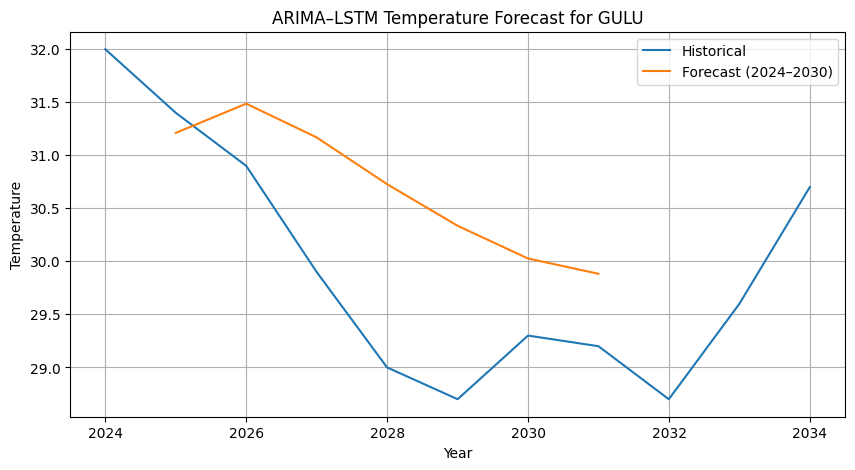


===== Forecast for KAMPALA =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),


        Date  Forecasted_Temperature
0 2024-12-31                  27.208
1 2025-12-31                  27.543
2 2026-12-31                  27.444
3 2027-12-31                  27.414
4 2028-12-31                  27.383
5 2029-12-31                  27.360
6 2030-12-31                  27.350


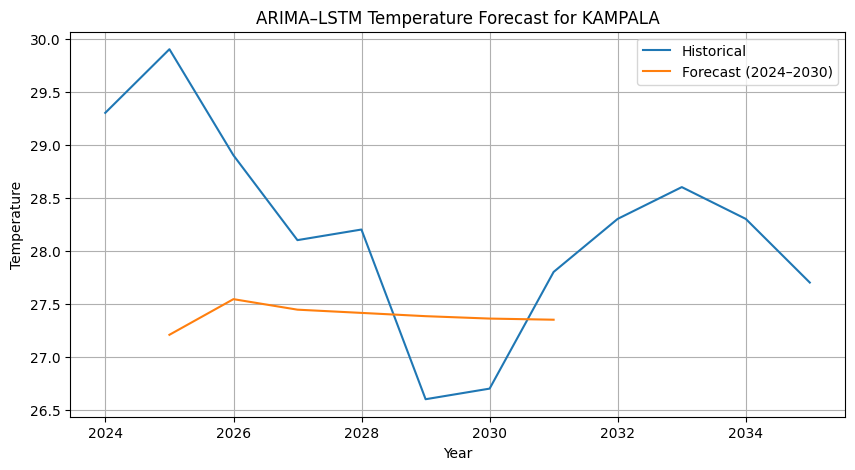


===== Forecast for KASESE =====


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-

        Date  Forecasted_Temperature
0 2024-12-31                  30.579
1 2025-12-31                  30.833
2 2026-12-31                  30.642
3 2027-12-31                  30.781
4 2028-12-31                  30.732
5 2029-12-31                  30.756
6 2030-12-31                  30.754


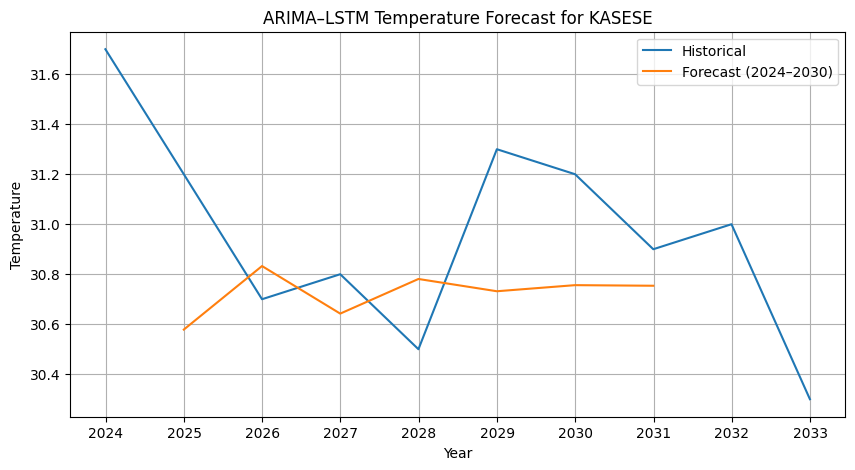


===== Forecast for LIRA =====


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is depr

        Date  Forecasted_Temperature
0 2024-12-31                  30.974
1 2025-12-31                  31.105
2 2026-12-31                  31.420
3 2027-12-31                  31.165
4 2028-12-31                  31.234
5 2029-12-31                  31.271
6 2030-12-31                  31.229


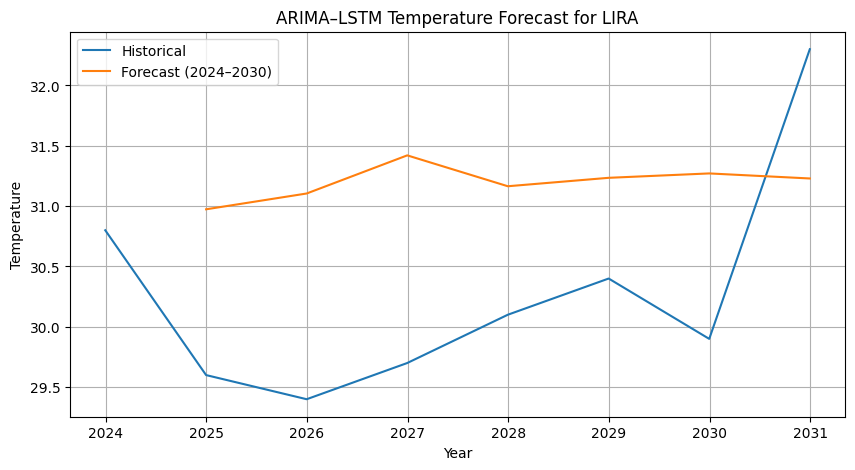


===== Forecast for MASINDI =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),


        Date  Forecasted_Temperature
0 2024-12-31                  29.715
1 2025-12-31                  29.840
2 2026-12-31                  29.767
3 2027-12-31                  29.677
4 2028-12-31                  29.678
5 2029-12-31                  29.654
6 2030-12-31                  29.638


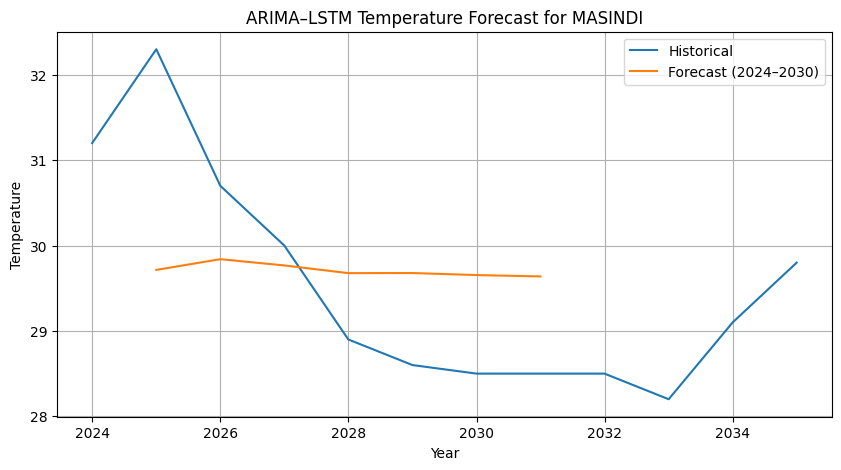


===== Forecast for JINJA =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


        Date  Forecasted_Temperature
0 2024-12-31                  28.302
1 2025-12-31                  28.188
2 2026-12-31                  28.117
3 2027-12-31                  28.069
4 2028-12-31                  28.051
5 2029-12-31                  28.031
6 2030-12-31                  28.017


/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),


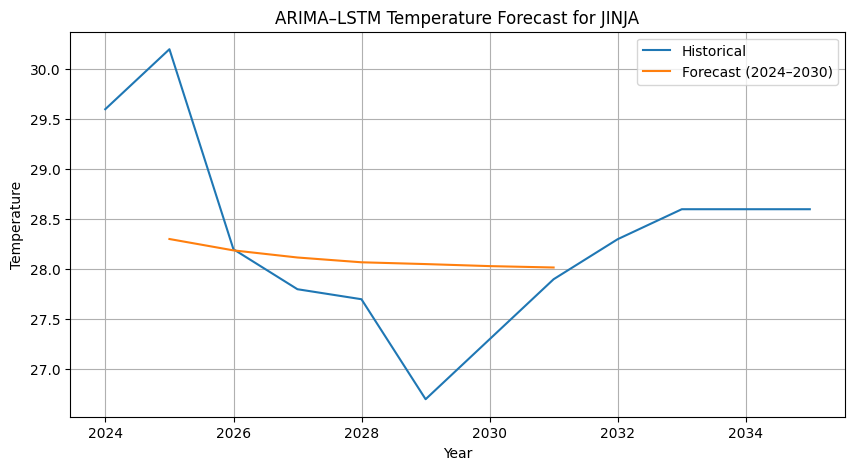


===== Forecast for MBARARA =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),


        Date  Forecasted_Temperature
0 2024-12-31                  27.281
1 2025-12-31                  27.085
2 2026-12-31                  27.232
3 2027-12-31                  27.086
4 2028-12-31                  27.084
5 2029-12-31                  27.089
6 2030-12-31                  27.067


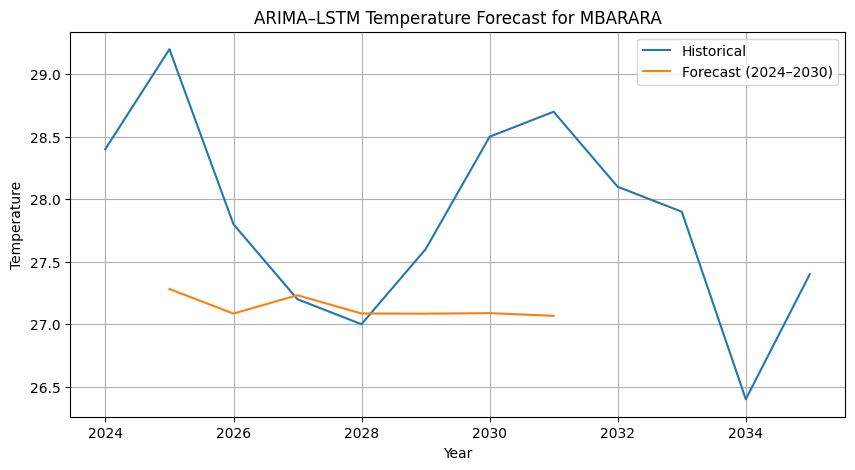


===== Forecast for KABALE =====


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),


        Date  Forecasted_Temperature
0 2024-12-31                  24.519
1 2025-12-31                  24.410
2 2026-12-31                  24.471
3 2027-12-31                  24.399
4 2028-12-31                  24.401
5 2029-12-31                  24.402
6 2030-12-31                  24.389


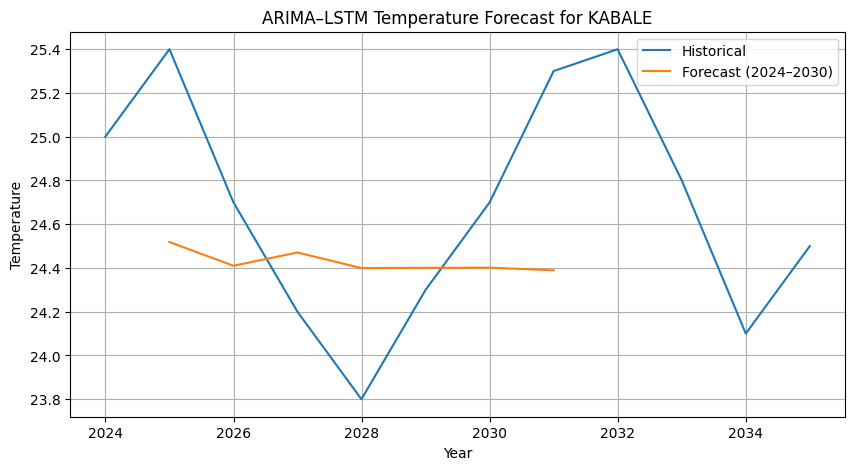


===== Forecast for SOROTI =====


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipython-input-2595962273.py:472: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_dates = pd.date_range(
/tmp/ipython-input-2595962273.py:493: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),


        Date  Forecasted_Temperature
0 2024-12-31                  30.161
1 2025-12-31                  29.689
2 2026-12-31                  29.095
3 2027-12-31                  28.279
4 2028-12-31                  27.910
5 2029-12-31                  27.895
6 2030-12-31                  28.179


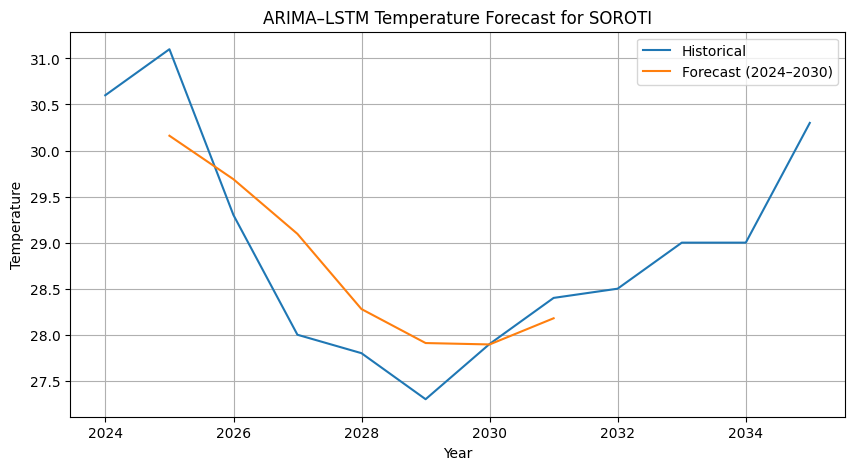

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from scipy.stats import pearsonr
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Step 2: Read dataset (already uploaded via files.upload())
file_path = "Temperature Data.xlsx"
df = pd.read_excel(file_path)
df.columns = ["City", "Temperature", "Urban_Population"]

# TRAIN TEST SPLIT
train_size = int(len(df_clean) * 0.7)
train = df_clean.iloc[:train_size]
test = df_clean.iloc[train_size:]

y_train = train["Temperature"].values
y_test = test["Temperature"].values
x_train = train["Urban_Population"].values
x_test = test["Urban_Population"].values

# PERFORMANCE METRICS
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, smape, r2

# DEEP LEARNING BENCHMARKS
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_clean[["Temperature"]])

def create_seq(data, n_steps=3):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Create sequences from the entire scaled dataset
X_seq, y_seq = create_seq(scaled)

# Determine the split points for deep learning data to align test set length with y_test
dl_test_samples = len(y_test)
dl_train_samples = len(y_seq) - dl_test_samples

X_train_dl_seq, X_test_dl_seq = X_seq[:dl_train_samples], X_seq[dl_train_samples:]
y_train_dl_seq, y_test_dl_seq = y_seq[:dl_train_samples], y_seq[dl_train_samples:]

# Generic builder for recurrent models, now accepting input_seq_shape
def build_model(cell, input_seq_shape, bidirectional=False):
    model = Sequential()

    if bidirectional:
        model.add(
            Bidirectional(
                cell(50, activation="tanh"),
                input_shape=input_seq_shape
            )
        )
    else:
        model.add(
            cell(50, activation="tanh", input_shape=input_seq_shape)
        )

    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

# ARIMA MODEL
# Train ARIMA on the training data
auto_arima = pm.auto_arima(y_train, seasonal=False)
arima_model = ARIMA(y_train, order=auto_arima.order).fit()

print("\nARIMA Parameters")
print(arima_model.params)

# Forecast for the test period
arima_pred = arima_model.forecast(len(y_test))

#ARIMA-LSTM HYBRID
# Calculate residuals from ARIMA model on TRAINING data
residuals_train = y_train - arima_model.fittedvalues
scaler_res = MinMaxScaler() # Use a separate scaler for residuals
res_scaled_train = scaler_res.fit_transform(residuals_train.reshape(-1,1))

# Create sequences for LSTM training from scaled residuals
n_steps = 3 # from create_seq function
Xr_train_res, yr_train_res = create_seq(res_scaled_train, n_steps=n_steps)
lstm_res = build_model(LSTM, (Xr_train_res.shape[1], 1)) # input_shape must be consistent with Xr_train_res
lstm_res.fit(Xr_train_res, yr_train_res, epochs=30, verbose=0)

# Forecast future residuals for the test period iteratively
res_forecast_list = []
# Initialize with the last n_steps of training residuals
current_input_res = res_scaled_train[-n_steps:].reshape(1, n_steps, 1)

for _ in range(len(y_test)):
    next_residual_scaled = lstm_res.predict(current_input_res, verbose=0)[0, 0] # verbose=0 to suppress output
    res_forecast_list.append(next_residual_scaled)
    # Update current_input by removing the first element and adding the new prediction
    # This creates a sliding window for multi-step forecasting
    current_input_res = np.append(current_input_res[:, 1:, :], [[[next_residual_scaled]]], axis=1)

res_forecast = scaler_res.inverse_transform(np.array(res_forecast_list).reshape(-1, 1)).flatten()
hybrid_pred = arima_pred + res_forecast

print("\nHybrid Model Parameters")
print(lstm_res.summary())


# FACEBOOK PROPHET
prophet_df = df_clean.reset_index()
prophet_df["ds"] = pd.date_range(start="2017", periods=len(prophet_df), freq="M")
prophet_df.rename(columns={"Temperature":"y"}, inplace=True)

model_p = Prophet()
model_p.fit(prophet_df.iloc[:train_size])

future = model_p.make_future_dataframe(periods=len(y_test), freq="M")
forecast = model_p.predict(future)
prophet_pred = forecast["yhat"].iloc[-len(y_test):].values

# MACHINE LEARNING BENCHMARKS

X_ml = df_clean[["Urban_Population"]]
y_ml = df_clean[["Temperature"]]
# Split ML data into train and test
X_train_ml, X_test_ml = X_ml.iloc[:train_size], X_ml.iloc[train_size:]
y_train_ml, y_test_ml = y_ml.iloc[:train_size], y_ml.iloc[train_size:]

ml_models = {
    "RandomForest": RandomForestRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "SVR": SVR(),
    "GBM": GradientBoostingRegressor(),
    "KNN": KNeighborsRegressor()
}

predictions = {}
for name, model in ml_models.items():
    # Train ML models on training data
    model.fit(X_train_ml, y_train)
    # Predict on test data
    pred = model.predict(X_test_ml)
    predictions[name] = pred
    print(f"\n{name} Parameters")
    print(model.get_params())

# Add Prophet predictions to the dictionary as well
predictions["Prophet"] = prophet_pred

# Deep learning models
# Build models with appropriate input shape for training data
models_dl = {
    "LSTM": build_model(LSTM, (X_train_dl_seq.shape[1], 1)),
    "RNN": build_model(SimpleRNN, (X_train_dl_seq.shape[1], 1)),
    "GRU": build_model(GRU, (X_train_dl_seq.shape[1], 1)),
    "BiLSTM": build_model(LSTM, (X_train_dl_seq.shape[1], 1), bidirectional=True),
    "BiGRU": build_model(GRU, (X_train_dl_seq.shape[1], 1), bidirectional=True),
    "BiRNN": build_model(SimpleRNN, (X_train_dl_seq.shape[1], 1), bidirectional=True),
}

# MLP requires flattened input
mlp = Sequential()
mlp.add(Dense(50, activation="relu", input_dim=X_train_dl_seq.shape[1]))
mlp.add(Dense(1))
mlp.compile(optimizer="adam", loss="mse")

models_dl["MLP"] = mlp

# Train deep learning models on training data and predict on test data
for name, model in models_dl.items():
    # Train on training sequences
    model.fit(X_train_dl_seq if name != "MLP" else X_train_dl_seq.reshape(X_train_dl_seq.shape[0], -1),
              y_train_dl_seq,
              epochs=30,
              verbose=0)

    # Predict on test sequences
    preds = model.predict(
        X_test_dl_seq if name != "MLP" else X_test_dl_seq.reshape(X_test_dl_seq.shape[0], -1),
        verbose=0 # Suppress predict output for each model
    )

    predictions[name] = scaler.inverse_transform(preds).flatten()

# MODEL COMPARISON
# Initialize results dictionary
results = {}

# Explicit list of deep learning benchmark models
deep_learning_models = [
    "LSTM",
    "RNN",
    "GRU",
    "BiGRU",
    "BiRNN",
    "MLP"
]

# Explicit list of machine learning benchmark models
machine_learning_models = [
    "RandomForest",
    "DecisionTree",
    "SVR",
    "GBM",
    "KNN"
]

# Add ARIMA
results["ARIMA"] = metrics(y_test, arima_pred)

# Add Facebook Prophet
results["Prophet"] = metrics(y_test, prophet_pred)

# Add ARIMA-LSTM Hybrid
results["ARIMA-LSTM"] = metrics(y_test, hybrid_pred)

# Add Deep Learning Models
for model in deep_learning_models:
    if model in predictions:
        results[model] = metrics(y_test, predictions[model])

# Add Machine Learning Models
for model in machine_learning_models:
    if model in predictions:
        results[model] = metrics(y_test, predictions[model])

# Create comparison table
results_df = pd.DataFrame(
    results,
    index=["RMSE", "MAE", "MAPE", "SMAPE", "R2"]
).T

# Sort models by RMSE (best on top)
results_df = results_df.sort_values(by="RMSE")

print("\nMODEL PERFORMANCE COMPARISON\n")
print(results_df.round(4))

# VISUALIZATION ACTUAL VS PREDICTED
for name in results_df.index[:-1]: # Iterate only over names
    plt.figure()
    plt.plot(y_test, label="Actual")
    # Check if the model name exists in predictions dictionary before plotting
    if name in predictions:
        plt.plot(predictions[name], label=name)
    else:
        # Handle cases where predictions might not be available for a model (e.g., ARIMA/ARIMA-LSTM are not in `predictions` yet)
        # For ARIMA and ARIMA-LSTM, their predictions are in `arima_pred` and `hybrid_pred` respectively.
        if name == "ARIMA":
            plt.plot(arima_pred, label=name)
        elif name == "ARIMA-LSTM":
            plt.plot(hybrid_pred, label=name)
        # Add other specific cases if any model's prediction is not in the `predictions` dict


    plt.legend()
    plt.title(f"Actual vs Predicted: {name}")
    plt.show()

# CORRELATION CHECK FOR HYBRID MODEL
# Correlation should be between actual test values and hybrid predictions for the test set
corr, _ = pearsonr(y_test, hybrid_pred)
print("\nCorrelation between Actual (Test) and Hybrid Prediction (Test):", corr)

# DERIVED CLASSIFICATION METRICS FOR ALL MODELS

# Binary temperature state based on median threshold
threshold = np.median(y_train)
y_test_cls = (y_test > threshold).astype(int)

def to_class(pred):
    return (pred > threshold).astype(int)

def to_prob(pred):
    return (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)

def classification_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Sensitivity": recall_score(y_true, y_pred),
        "F1_score": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob)
    }

# Collect predictions consistently
all_predictions = {
    "ARIMA": arima_pred,
    "Prophet": prophet_pred,
    "ARIMA-LSTM": hybrid_pred,
    **predictions  # DL and ML models
}

cls_results = {}

for model_name, y_hat in all_predictions.items():
    if y_hat is not None:
        cls_results[model_name] = classification_metrics(
            y_test_cls,
            to_class(y_hat),
            to_prob(y_hat)
        )

cls_df = pd.DataFrame(cls_results).T.round(4)

print("\nCLASSIFICATION METRICS (Derived Temperature States)\n")
print(cls_df)

# TIME SERIES CROSS VALIDATION WITH RMSE

tscv = TimeSeriesSplit(n_splits=5)

def cv_rmse(model, X, y):
    rmses = []
    for train_idx, test_idx in tscv.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        pred = model.predict(X.iloc[test_idx])
        rmses.append(np.sqrt(mean_squared_error(y.iloc[test_idx], pred)))
    return np.mean(rmses)

cv_scores = {}

for name, model in ml_models.items():
    cv_scores[name] = cv_rmse(model, X_ml, y_ml.squeeze())

print("\nTIME SERIES CROSS VALIDATION RMSE\n")
print(pd.Series(cv_scores).round(4))

# HYPERPARAMETER TUNING FOR ML BENCHMARK MODELS

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, None]
    },
    "DecisionTree": {
        "max_depth": [3, 5, None]
    },
    "SVR": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"]
    },
    "GBM": {
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7]
    }
}

best_models = {}

for name, grid in param_grids.items():
    gcv = GridSearchCV(
        ml_models[name],
        grid,
        scoring="neg_root_mean_squared_error",
        cv=tscv
    )
    gcv.fit(X_train_ml, y_train)
    best_models[name] = gcv.best_estimator_

    print(f"\nBest Hyperparameters for {name}")
    print(gcv.best_params_)

# PREDICTION INTERVAL COVERAGE

coverage = {}

for model_name, pred in all_predictions.items():
    if pred is not None:
        sigma = np.std(pred)
        lower = pred - 1.96 * sigma
        upper = pred + 1.96 * sigma
        coverage[model_name] = np.mean(
            (y_test >= lower) & (y_test <= upper)
        )

coverage_df = pd.Series(coverage).round(4)

print("\nPREDICTION INTERVAL COVERAGE (95 percent)\n")
print(coverage_df)

# FORECASTING TEMPERATURE DYNAMICS FOR NEXT 7 YEARS USING ARIMA LSTM

# ============================
# 7 YEAR AHEAD FORECAST (2024–2030)
# ARIMA–LSTM HYBRID
# ============================

forecast_horizon = 7  # 7 years annual forecast

cities = df_clean["City"].unique()

forecast_results = {}

for city in cities:
    print(f"\n===== Forecast for {city} =====")

    city_df = df_clean[df_clean["City"] == city].reset_index(drop=True)
    y_city = city_df["Temperature"].values

    # ----------------------------
    # ARIMA component
    # ----------------------------
    auto_arima_city = pm.auto_arima(y_city, seasonal=False, suppress_warnings=True)
    arima_city = ARIMA(y_city, order=auto_arima_city.order).fit()

    arima_forecast = arima_city.forecast(steps=forecast_horizon)

    # ----------------------------
    # LSTM residual component
    # ----------------------------
    residuals_city = y_city - arima_city.fittedvalues

    scaler_city = MinMaxScaler()
    residuals_scaled = scaler_city.fit_transform(residuals_city.reshape(-1, 1))

    Xr_city, yr_city = create_seq(residuals_scaled, n_steps=n_steps)

    lstm_city = build_model(LSTM, (Xr_city.shape[1], 1))
    lstm_city.fit(Xr_city, yr_city, epochs=30, verbose=0)

    # Iterative residual forecasting
    res_future = []
    current_input = residuals_scaled[-n_steps:].reshape(1, n_steps, 1)

    for _ in range(forecast_horizon):
        next_res = lstm_city.predict(current_input, verbose=0)[0, 0]
        res_future.append(next_res)
        current_input = np.append(
            current_input[:, 1:, :],
            [[[next_res]]],
            axis=1
        )

    res_future = scaler_city.inverse_transform(
        np.array(res_future).reshape(-1, 1)
    ).flatten()

    # ----------------------------
    # Hybrid forecast
    # ----------------------------
    hybrid_forecast = arima_forecast + res_future

    # Time index
    forecast_dates = pd.date_range(
        start="2024-12-31",
        periods=forecast_horizon,
        freq="Y"
    )

    forecast_df = pd.DataFrame({
        "Date": forecast_dates,
        "Forecasted_Temperature": hybrid_forecast
    })

    forecast_results[city] = forecast_df

    # Print first 7 years for reporting
    print(forecast_df.head(7).round(3))

    # ----------------------------
    # Plot
    # ----------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(
        pd.date_range(start="2023-12-31", periods=len(y_city), freq="Y"),
        y_city,
        label="Historical"
    )
    plt.plot(
        forecast_df["Date"],
        forecast_df["Forecasted_Temperature"],
        label="Forecast (2024–2030)"
    )
    plt.title(f"ARIMA–LSTM Temperature Forecast for {city}")
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    plt.legend()
    plt.grid(True)
    plt.show()